In [2]:
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

metrics_files = Path('../evaluation/').rglob('*_metrics.json')


# Load each json file into a list of dictionaries
metrics_list = []
for json_file in metrics_files:
    with open(json_file) as f:
        # if len(model_parts) > 2 and model_parts[2] == "2024":
        #     continue
        metrics = json.load(f)
        # Extract subontology from model name (last part after splitting by -)
        model_parts = metrics['model'].split('-')
        metrics['model_name'] = model_parts[0]
        metrics['subontology'] = model_parts[1]
        # Remove subontology from model name
        metrics['ont_version'] = model_parts[2] if model_parts[0] == "contempro" else '2020'
        if metrics["ont_version"] == "2024":
            continue
        metrics['model_variant'] = '-'.join(model_parts[3:]) if len(model_parts) > 3 else '-'
        # Add source type
        metrics_list.append(metrics)

# Convert list of dictionaries to pandas DataFrame
df = pd.DataFrame(metrics_list)
# Pivot and prepare the data
df_pivoted = df.pivot_table(
    index=['subontology', 'model_name', 'ont_version', 'model_variant'],
    values=['Macro AUPR', 'AUC', 'Fmax']
).reset_index()


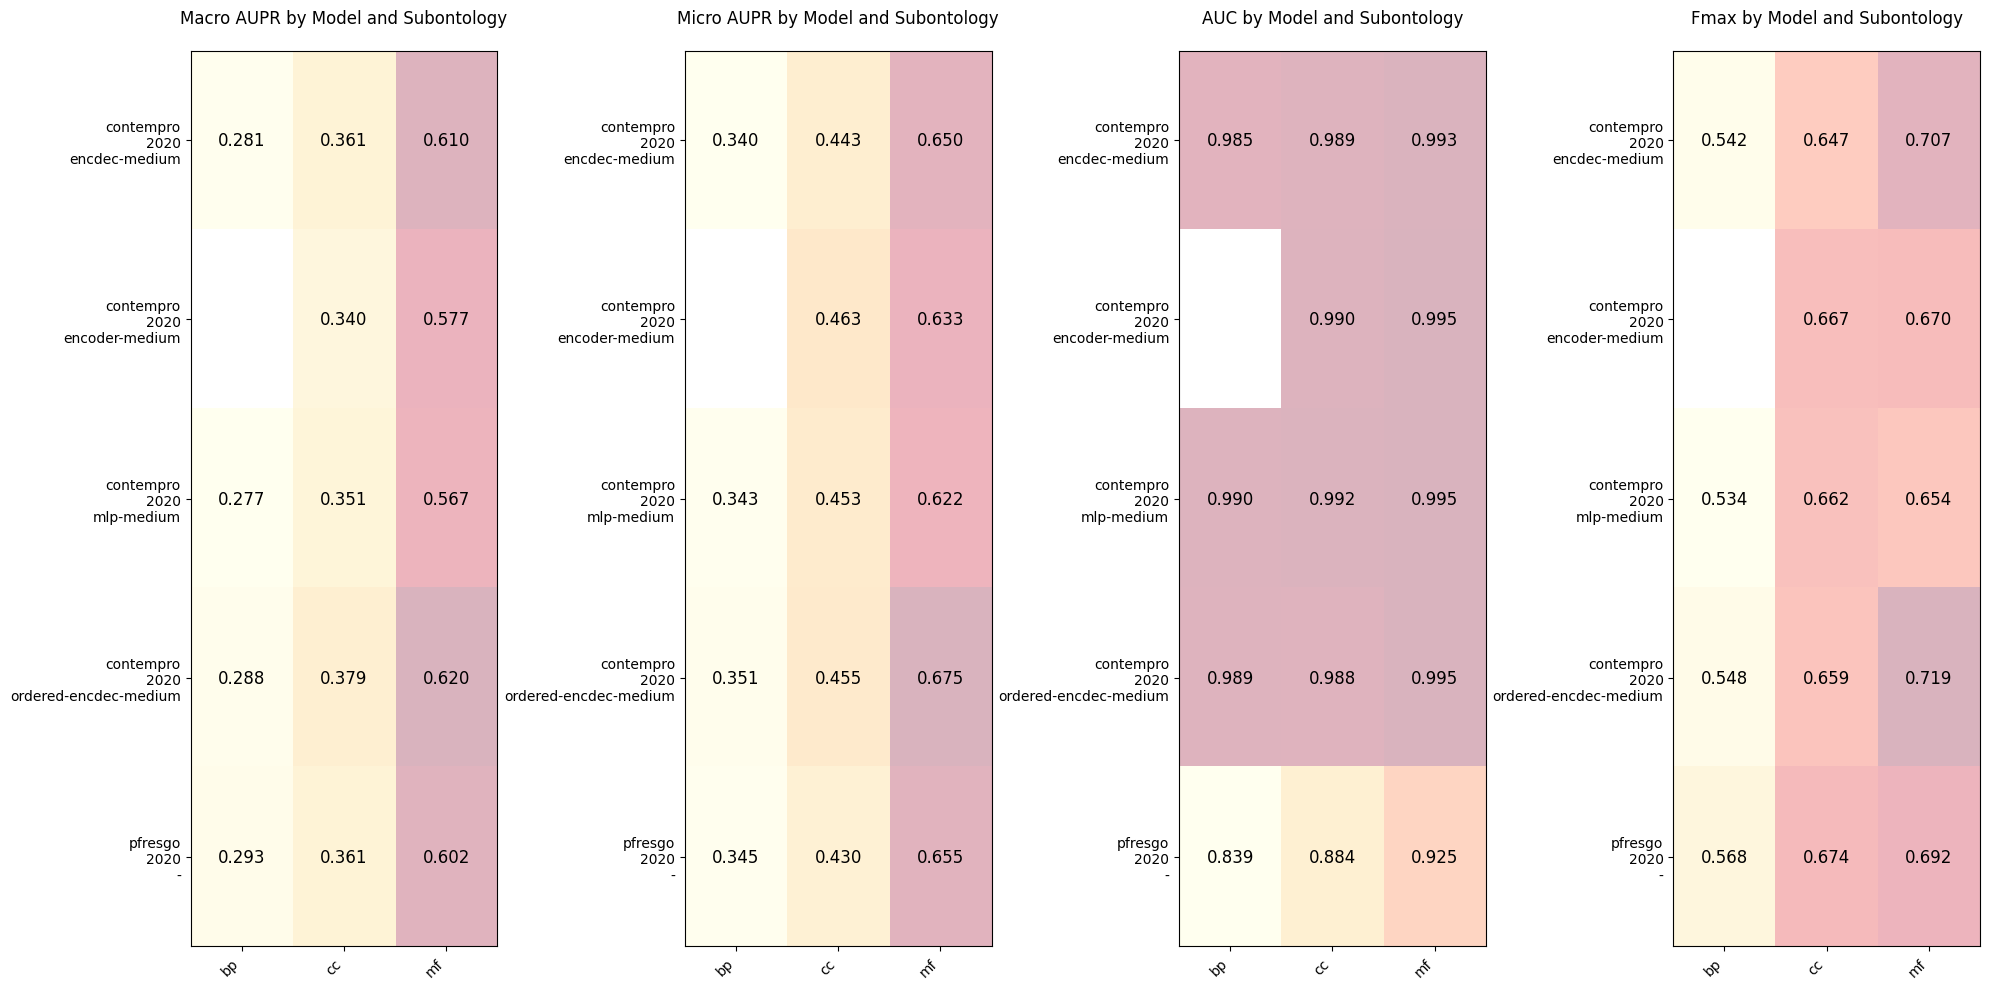

In [2]:
# Create a figure with subplots for each metric
fig, axes = plt.subplots(1, 4, figsize=(20, 10))
metrics = ['Macro AUPR','Micro AUPR', 'AUC', 'Fmax']

# Plot each metric
for i, metric in enumerate(metrics):
    plot_data = df.pivot_table(
        index=['model_name', 'ont_version', 'model_variant'],
        columns='subontology',
        values=metric
    )

    # Create heatmap
    im = axes[i].imshow(plot_data, cmap='YlOrRd', aspect='auto', alpha=0.3)

    # Customize subplot
    axes[i].set_title(f'{metric} by Model and Subontology', pad=20)
    axes[i].set_xticks(np.arange(len(plot_data.columns)))
    axes[i].set_yticks(np.arange(len(plot_data.index)))
    axes[i].set_xticklabels(plot_data.columns)

    # Format y-labels to be more compact
    ylabels = [f"{idx[0]}\n{idx[1]}\n{idx[2]}" for idx in plot_data.index]
    axes[i].set_yticklabels(ylabels)

    # Rotate x labels
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right")

    # Add colorbar
    #plt.colorbar(im, ax=axes[i])

    # Add text annotations with color based on value
    for j in range(len(plot_data.index)):
        for k in range(len(plot_data.columns)):
            value = plot_data.iloc[j, k]
            if not pd.isna(value):
                # Calculate the threshold for text color
                # Get the min and max values for current metric
                vmin = plot_data.values.min()
                vmax = plot_data.values.max()
                threshold = (vmax - vmin) * 0.7 + vmin  # Adjust this value to change when text becomes white

                # Choose text color based on cell value
                text_color = 'white' if value >= threshold else 'black'

                text = axes[i].text(k, j, f'{value:.3f}',
                                  ha="center", va="center",
                                  color=text_color,
                                  fontsize=12,
                                  )

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/1178681084.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/1178681084.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/1178681084.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/1178681084.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']


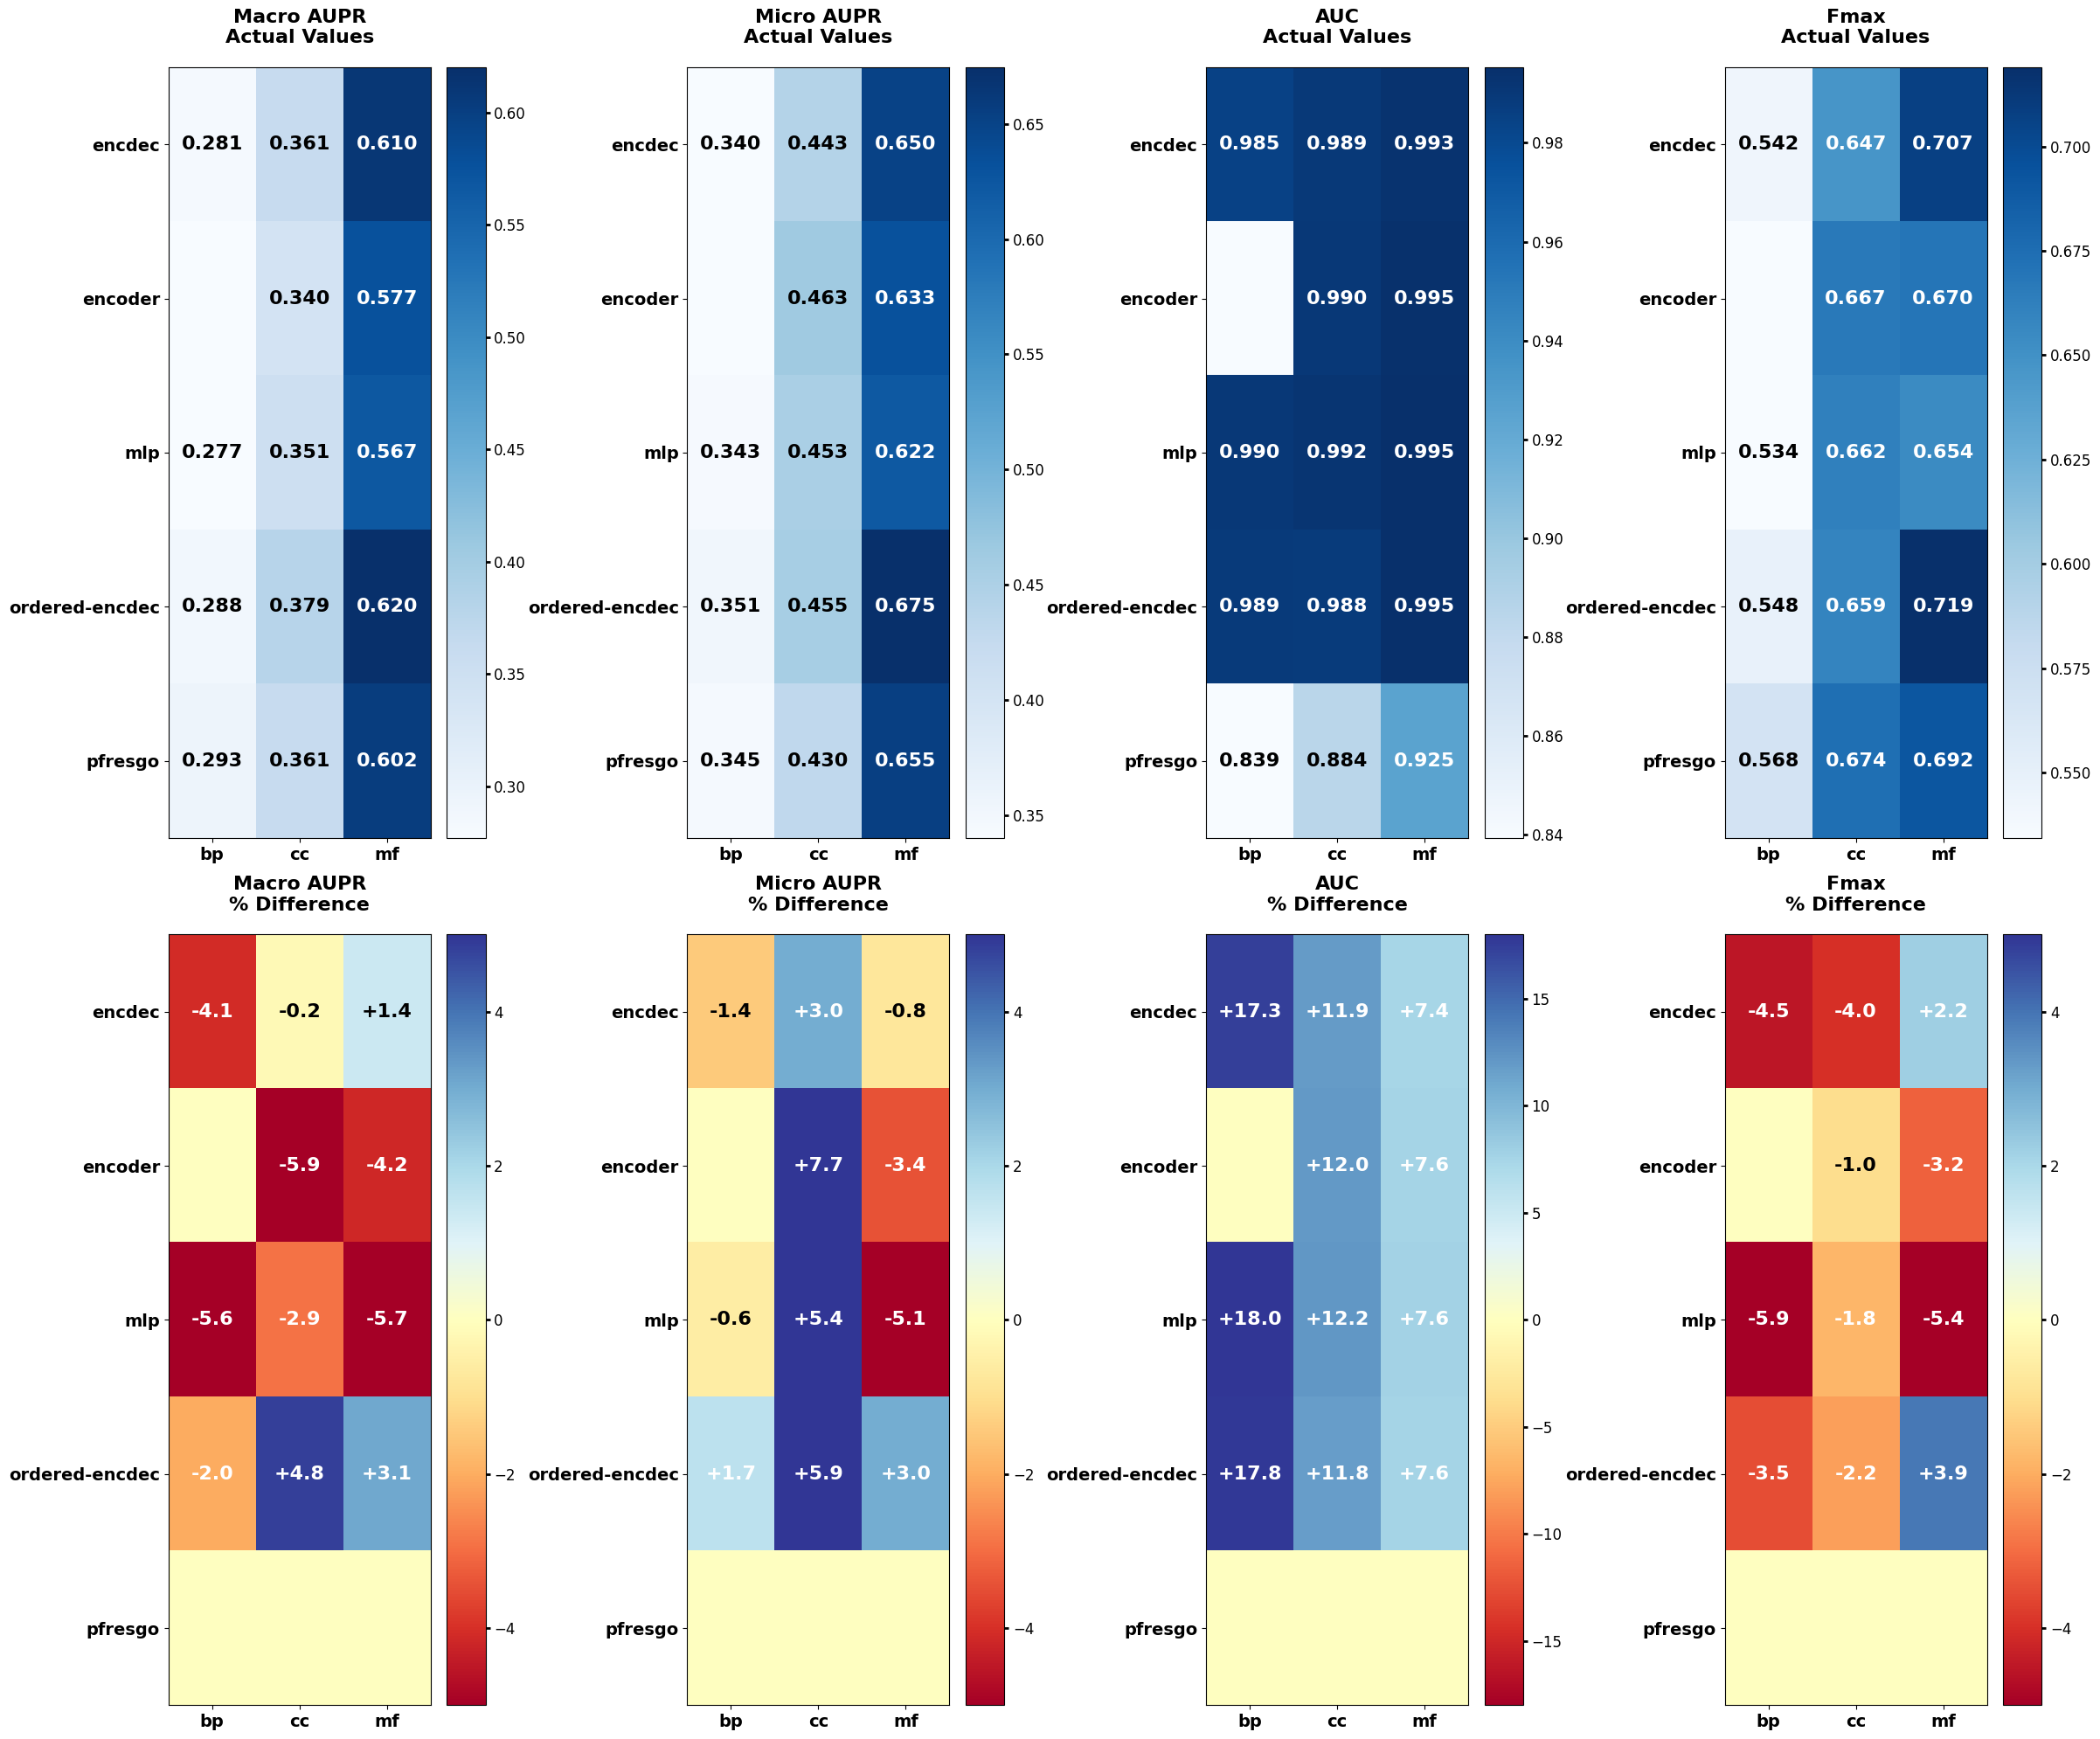

In [6]:
# Create figure with custom size ratio
fig, axes = plt.subplots(2, 4, figsize=(24, 20))
metrics = ['Macro AUPR', 'Micro AUPR', 'AUC', 'Fmax']

# Function to clean model names
def clean_model_name(name, ont_version, variant):
    if name == 'contempro':
        return f"{variant.replace('-medium', '')}"
    return name


# Custom colormaps - using blues for actual values and blue-white-orange for differences
cmap_actual = plt.cm.Blues  # Changed from gray to Blues
cmap_diff = plt.cm.RdYlBu    # Changed from RdYlGn to RdYlBu for poster consistency

for i, metric in enumerate(metrics):
    norm_diff = plt.Normalize(vmin=-5, vmax=5)
    if metric == "AUC":
        norm_diff = plt.Normalize(vmin=-18, vmax=18)
    # Get baseline values
    baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
    baseline_values = {}
    for subont in ['bp', 'cc', 'mf']:
        baseline_values[subont] = baseline_df[baseline_df['subontology'] == subont][metric].iloc[0]

    # Prepare data
    plot_data_actual = []
    plot_data_diff = []
    clean_index = []

    for name, group in df.groupby(['model_name', 'ont_version', 'model_variant']):
        row_actual = []
        row_diff = []
        for subont in ['bp', 'cc', 'mf']:
            subont_data = group[group['subontology'] == subont]
            if not subont_data.empty:
                value = subont_data[metric].iloc[0]
                row_actual.append(value)
                diff = ((value - baseline_values[subont]) / baseline_values[subont]) * 100
                row_diff.append(diff)
            else:
                row_actual.append(0)
                row_diff.append(0)

        if row_actual:
            plot_data_actual.append(row_actual)
            plot_data_diff.append(row_diff)
            clean_index.append(clean_model_name(name[0], name[1], name[2]))

    # Create DataFrames
    plot_data_actual = pd.DataFrame(plot_data_actual,
                                  columns=['bp', 'cc', 'mf'],
                                  index=clean_index)
    plot_data_diff = pd.DataFrame(plot_data_diff,
                                columns=['bp', 'cc', 'mf'],
                                index=clean_index)

    # Calculate min/max excluding zeros for better color scaling
    actual_nonzero = plot_data_actual[plot_data_actual != 0]
    norm_actual = plt.Normalize(vmin=actual_nonzero.min().min(),
                              vmax=actual_nonzero.max().max())

    # Plot actual values and differences
    for row, (data, title_suffix, cmap, norm) in enumerate([
        (plot_data_actual, 'Actual Values', cmap_actual, norm_actual),
        (plot_data_diff, '% Difference', cmap_diff, norm_diff)
    ]):
        im = axes[row, i].imshow(data,
                                cmap=cmap,
                                norm=norm,
                                aspect='auto',
                                interpolation='nearest')

        # Customize subplot
        axes[row, i].set_title(f'{metric}\n{title_suffix}',
                              pad=20,
                              fontsize=16,
                              fontweight='bold')
        axes[row, i].set_xticks(np.arange(len(data.columns)))
        axes[row, i].set_yticks(np.arange(len(data.index)))
        axes[row, i].set_xticklabels(data.columns,
                                    fontsize=14,
                                    fontweight='bold')
        axes[row, i].set_yticklabels(data.index,
                                    fontsize=14,
                                    fontweight='bold')

        # Add text annotations
        for j in range(len(data.index)):
            for k in range(len(data.columns)):
                value = data.iloc[j, k]

                # Skip text for 0.0 values
                if value == 0:
                    continue

                if row == 0:  # Actual values
                    text = f"{value:.3f}"
                    threshold = (actual_nonzero.max().max() + actual_nonzero.min().min()) / 2
                    text_color = 'white' if value > threshold else 'black'
                else:  # Differences
                    text = f"{value:+.1f}" if abs(value) >= 0.1 else ""
                    text_color = 'white' if abs(value) > 1.5 else 'black'

                axes[row, i].text(k, j, text,
                                ha="center", va="center",
                                color=text_color,
                                fontsize=16,
                                fontweight='bold')

        # Add colorbar with larger text
        cbar = plt.colorbar(im, ax=axes[row, i])
        cbar.ax.tick_params(labelsize=12, width=2)

plt.tight_layout()
plt.savefig('heatmap_visualization.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/3818455929.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/3818455929.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/3818455929.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
/var/folders/pb/_0h8x45x091307x0pwzykw8h0000gn/T/ipykernel_985/3818455929.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']


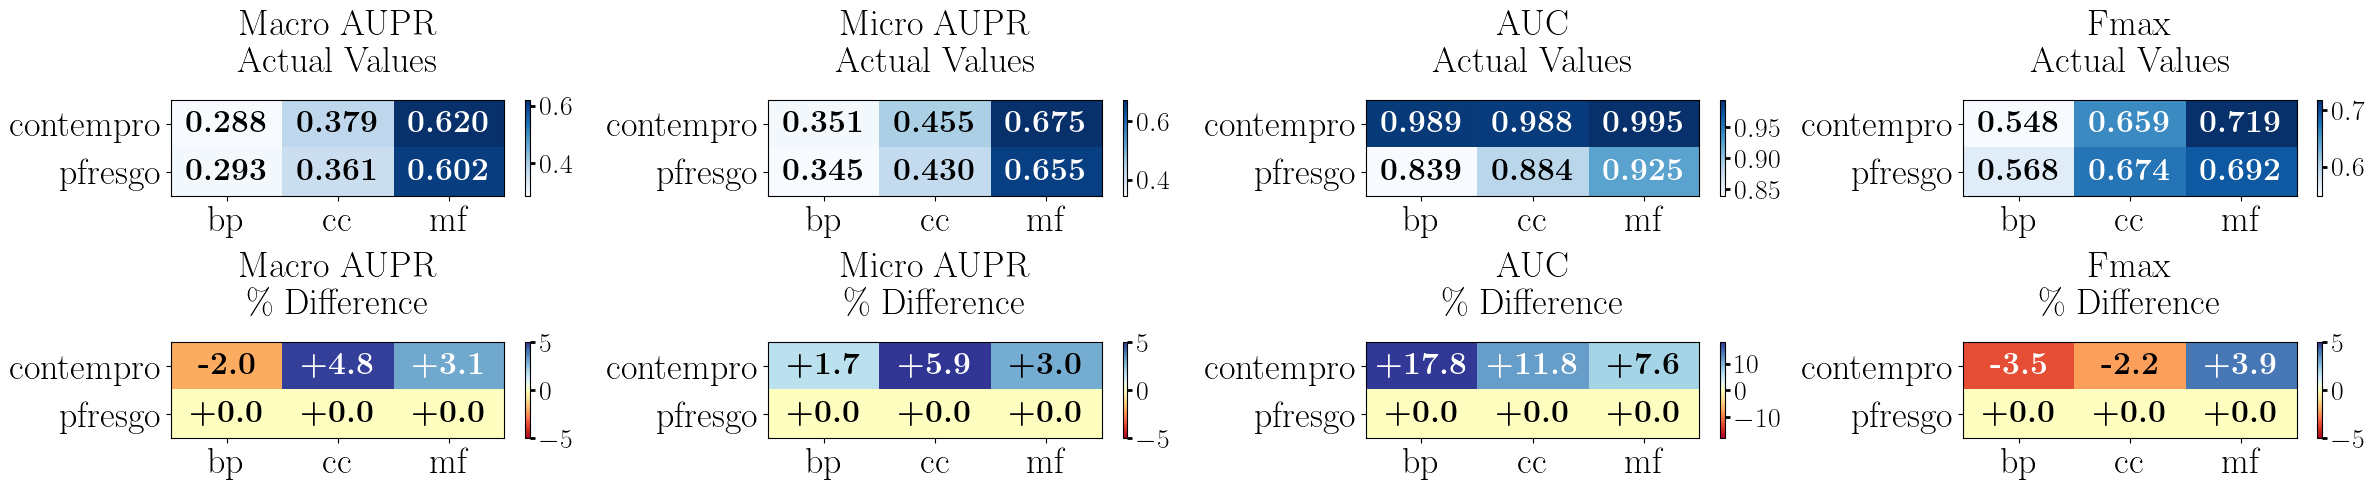

In [26]:
# Create figure with custom size ratio
#plt.rcParams['font.family'] = 'NewComputerModern10'
plt.rcParams['text.usetex'] = True
plt.rcParams['svg.fonttype'] = 'none'
fig, axes = plt.subplots(2, 4, figsize=(24, 5))
metrics = ['Macro AUPR', 'Micro AUPR', 'AUC', 'Fmax']

# Custom colormaps
cmap_actual = plt.cm.Blues
cmap_diff = plt.cm.RdYlBu

for i, metric in enumerate(metrics):
    if metric == "AUC":
        norm_diff = plt.Normalize(vmin=-18, vmax=18)
    else:
        norm_diff = plt.Normalize(vmin=-5, vmax=5)

    # Get baseline values
    baseline_df = df[df['model_name'] == 'pfresgo'][df['ont_version'] == '2020']
    baseline_values = {}
    for subont in ['bp', 'cc', 'mf']:
        baseline_values[subont] = baseline_df[baseline_df['subontology'] == subont][metric].iloc[0]

    # Prepare data - only for ordered-encdec and pfresgo
    plot_data_actual = []
    plot_data_diff = []
    clean_index = []

    for name, group in df.groupby(['model_name', 'ont_version', 'model_variant']):
        if name[2] not in ['ordered-encdec-medium'] and name[0] != 'pfresgo':
            continue

        row_actual = []
        row_diff = []
        for subont in ['bp', 'cc', 'mf']:
            subont_data = group[group['subontology'] == subont]
            if not subont_data.empty:
                value = subont_data[metric].iloc[0]
                row_actual.append(value)
                diff = ((value - baseline_values[subont]) / baseline_values[subont]) * 100
                row_diff.append(diff)
            else:
                row_actual.append(0)
                row_diff.append(0)

        if row_actual:
            plot_data_actual.append(row_actual)
            plot_data_diff.append(row_diff)
            # Rename ordered-encdec to contempro
            model_name = 'contempro' if 'ordered-encdec' in name[0] else name[0]
            clean_index.append(model_name)

    # Create DataFrames
    plot_data_actual = pd.DataFrame(plot_data_actual,
                                  columns=['bp', 'cc', 'mf'],
                                  index=clean_index)
    plot_data_diff = pd.DataFrame(plot_data_diff,
                                columns=['bp', 'cc', 'mf'],
                                index=clean_index)

    # Calculate min/max excluding zeros for better color scaling
    actual_nonzero = plot_data_actual[plot_data_actual != 0]
    norm_actual = plt.Normalize(vmin=actual_nonzero.min().min(),
                              vmax=actual_nonzero.max().max())

    # Plot actual values and differences
    for row, (data, title_suffix, cmap, norm) in enumerate([
        (plot_data_actual, 'Actual Values', cmap_actual, norm_actual),
        (plot_data_diff, '\\% Difference', cmap_diff, norm_diff)
    ]):
        im = axes[row, i].imshow(data,
                                cmap=cmap,
                                norm=norm,
                                aspect='auto',
                                interpolation='nearest')

        # Customize subplot
        axes[row, i].set_title(f'{metric}\n{title_suffix}',
                              pad=20,
                              fontsize=26,
                              fontweight='bold')
        axes[row, i].set_xticks(np.arange(len(data.columns)))
        axes[row, i].set_yticks(np.arange(len(data.index)))
        axes[row, i].set_xticklabels(data.columns,
                                    fontsize=26,
                                    fontweight='bold')
        axes[row, i].set_yticklabels(data.index,
                                    fontsize=26,
                                    fontweight='bold')

        # Add text annotations
        for j in range(len(data.index)):
            for k in range(len(data.columns)):
                value = data.iloc[j, k]

                # Skip text for 0.0 values
                # if value == 0:
                #     continue

                if row == 0:  # Actual values
                    text = f"{value:.3f}"
                    threshold = (actual_nonzero.max().max() + actual_nonzero.min().min()) / 2
                    text_color = 'white' if value > threshold else 'black'
                else:  # Differences
                    text = f"{value:+.1f}" #if abs(value) >= 0.1 else ""
                    text_color = 'white' if abs(value) > 3 * (3.5 if metric == "AUC" else 1) else 'black'

                axes[row, i].text(k, j, "\\textbf{" + text + "}",
                                ha="center", va="center",
                                color=text_color,
                                fontsize=23,
                                fontweight='bold')

        # Add colorbar with larger text
        cbar = plt.colorbar(im, ax=axes[row, i])
        cbar.ax.tick_params(labelsize=20, width=2)

plt.tight_layout()
plt.savefig('heatmap_visualization.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()